# Проект P07 "Ford vs Ferrari"
## Файл Pr07_11_EfficientNetB0

Цель проекта - знакомство с алгоритмами компьютерного зрения и изучение задачи мультиклассовой классификации по изображениям. Работа над проектом осуществляется в ряде ноутбуков. Ноутбук как правило предназначен для выполнения какой-то задачи - создания файла для загрузки на Kaggle или проведения эксперимента.  Ненужные куски кода - остатки от прошлых экспериментов - закрываются кавычками или диезом. 





Предварительно деформированные данные разворачиваются из архива, хранящегося на Google disk. 

In [1]:
!pwd

/content


In [2]:
# Проверяем что у нас работает GPU

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fd0637af-701f-1990-243d-402ff1c9e3ec)


In [3]:
!unzip -q -o /content/drive/MyDrive/DS/Pr07_FvF/Stretch_380.zip -d ./images


Пробное создание генераторов изображений и просмотр загруженных картинок.


In [4]:
sample_submission_path = '/content/images/sample-submission.csv'
subm_path = '/content/drive/MyDrive/DS/Pr07_FvF/Submissions/'
train_path = '/content/images/train/'
test_path = '/content/images/test/'

#имена классов
class_names = [ 
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras import Sequential
#from tensorflow.keras.applications import EfficientNetB0
#from tensorflow.keras.layers import GlobalMaxPool2D, Dropout, Dense
#from tensorflow.keras.losses import CategoricalCrossentropy
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
import albumentations as A

from itertools import islice
import numpy as np, pandas as pd, matplotlib.pyplot as plt


Делаю генераторы данных с альбументацией на уровне ImageDataGenerator. 

In [6]:
image_size = (380,380) #(224,224)  #(90, 120)
batch_size = 32
validation_share = 0.2
# color_mode = One of "grayscale", "rgb", "rgba". Default: "rgb".
# RANDOM_SEED = 17

def albument(image): 
  image = image.astype(np.uint8)
  augmentations = A.Compose([
    # flips
    A.HorizontalFlip(p=0.25),
    # Brightness 
    # A.RandomBrightness(limit=0.1, p=0.5),
    # A.RandomContrast(limit=0.1,p=0.25),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
    # Rotation
    A.Rotate(limit=10,p=0.5)
  ])
  return augmentations(image=image)['image']



train_datagen = ImageDataGenerator(
    #rescale=1/255,
    # color_mode = 'grayscale'
    validation_split=validation_share,
    preprocessing_function=albument,
    # ниже параметры аугментаций:
    # horizontal_flip=True,
    #zoom_range = 0.10,
    # rotation_range=10,
    #shear_range=0.10,
    #brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=validation_share,
)

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,  #False для анализа данных
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=test_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12449 images belonging to 10 classes.
Found 3108 images belonging to 10 classes.
Found 6675 validated image filenames.


In [7]:
def show_first_images(generator, count=5, labels=True, figsize=(20, 5), normalized=False):
  generator = islice(generator, count)  #itertools.islice
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()


In [8]:
 
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    print('Training of',len(acc),'epochs')

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Просмотр картинок. 

Train:


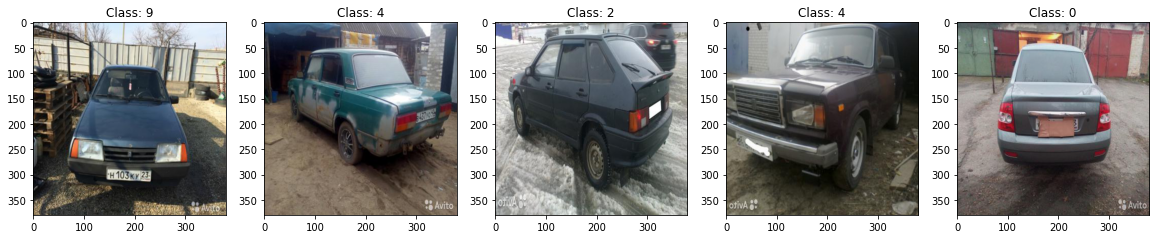



Val:


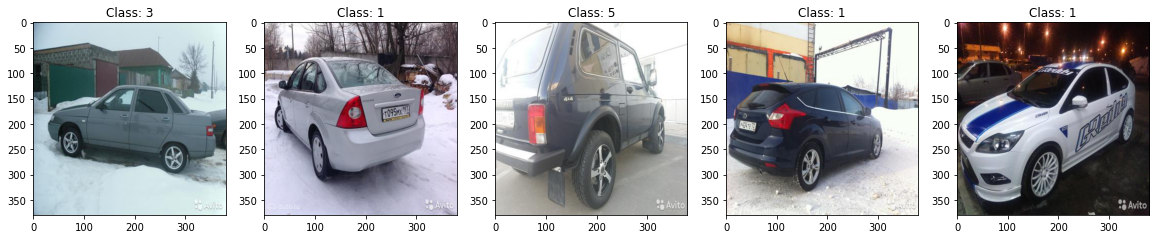



Sub:


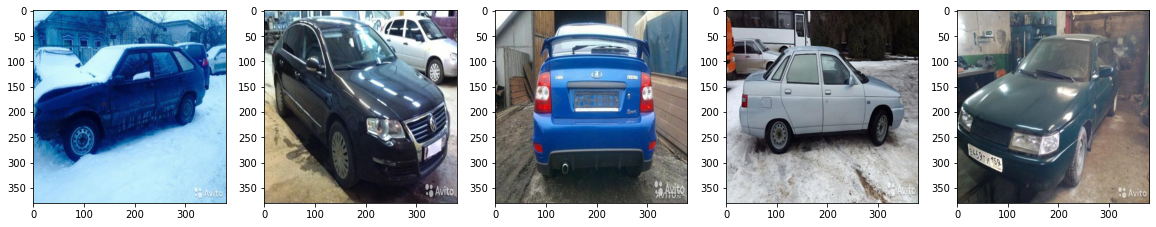

In [9]:

print('Train:')
show_first_images(train_generator)

print('\n\nVal:')
show_first_images(val_generator)

print('\n\nSub:')
show_first_images(sub_generator, labels=False)

In [10]:
# Добавим ModelCheckpoint. 
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, mode = 'max', save_best_only=True)
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [11]:
# строим модель - сохраняем это легаси код
# model = Sequential([
#  EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False), #предобученная нейросеть из модуля keras.applications
#  GlobalMaxPool2D(),
#  Dropout(0.5),
#  Dense(10)
# ])

#Пробую другой хвостик у модели - чуть более длинный. 
# Это сейчас основной вариант - показывает чуть лучший результат. 

model = Sequential([
  EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False), #предобученная нейросеть из модуля keras.applications
  GlobalAveragePooling2D(),
  Dense(256,activation='relu', bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)),
  BatchNormalization(),
  Dropout(0.25),
  Dense(10)
])

# Ниже кусок от попытки построить составную модель из трех. 

# base_model=EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False)

# К сожалению повторить состав входной аугментации не получилось.  
# preprocessing = Sequential([
#  RandomFlip(mode='horizontal'),
#  # RandomTranslation(0.1,0.1),    #сдвиг изображения по вертикали или горизонтали
#  RandomZoom(0.1),  #было 0.2
#  RandomRotation(0.05),   #фактор ротации задается в долях от 2Pi().  10 градусов из прошлого опыта примерно соответствуют 0.175
#  RandomContrast(0.1)  #было 0.2
#])

#tail = Sequential([GlobalMaxPooling2D(),Dropout(0.5),Dense(10)])

#model = Sequential([preprocessing, base_model, tail])

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    #0.96 - лучшаяя сходимость 
    #0.97 - возможен уникальный выдающийся результата
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.96)),  
    metrics='accuracy'
)

16719872/16705208 [==============================] - 0s 0us/step


In [12]:
# обучаем модель  НЕ БОЛЬШЕ 25 эпох!
history=model.fit(train_generator, validation_data=val_generator, epochs=25, callbacks = callbacks_list )

Epoch 1/25
390/390 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.8173
Epoch 00001: val_accuracy improved from -inf to 0.92407, saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


390/390 [==============================] - 383s 933ms/step - loss: 0.5363 - accuracy: 0.8173 - val_loss: 0.2318 - val_accuracy: 0.9241
Epoch 2/25
390/390 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9407
Epoch 00002: val_accuracy improved from 0.92407 to 0.93983, saving model to best_model.hdf5
390/390 [==============================] - 369s 946ms/step - loss: 0.1723 - accuracy: 0.9407 - val_loss: 0.2106 - val_accuracy: 0.9398
Epoch 3/25
390/390 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9635
Epoch 00003: val_accuracy improved from 0.93983 to 0.94627, saving model to best_model.hdf5
390/390 [==============================] - 369s 945ms/step - loss: 0.1107 - accuracy: 0.9635 - val_loss: 0.1796 - val_accuracy: 0.9463
Epoch 4/25
390/390 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9714
Epoch 00004: val_accuracy improved from 0.94627 to 0.95849, saving model to best_model.hdf5
390/390 [======================

In [13]:
print('Complete in',len(history.history['accuracy']),'epoch(s)')
print('Best score: %.5f' % model.evaluate(val_generator, verbose=1)[1])

Complete in 13 epoch(s)
98/98 [==============================] - 17s 173ms/step - loss: 0.1402 - accuracy: 0.9694
Best score: 0.96943


In [14]:
model.load_weights('best_model.hdf5')
scores = model.evaluate(val_generator, verbose=1)
print("Accuracy: %.4f" % (scores[1]))

98/98 [==============================] - 17s 174ms/step - loss: 0.1402 - accuracy: 0.9694
Accuracy: 0.9694


Training of 13 epochs


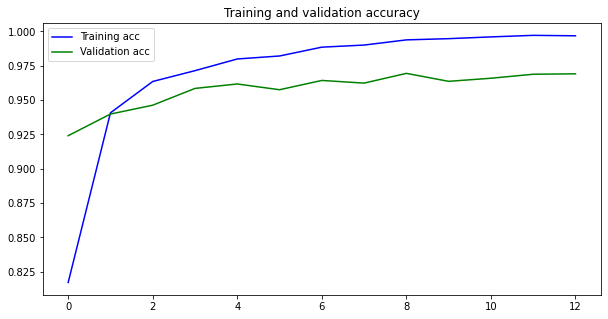

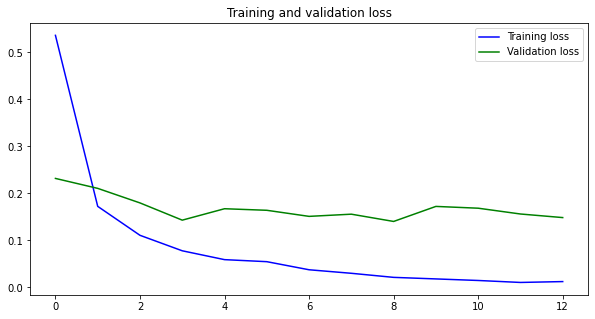

In [15]:
plot_history(history)

Сохранение обученной модели для последующего использования. 



In [16]:
# accur = str(round(scores[1]*100000))
# model_path = '/content/drive/MyDrive/DS/Pr07_FvF/Models'
# model.save_weights(model_path + '/ENB0'+accur+'.hdf5')

Проба анализа данных. Выснено, что сложно отличить капоты 2109 и 21099 - что естественно. 

In [17]:
'''
# Перед созданием предсказания необходимо отключить перетасовку данных в генераторе val_generator:  Shuffle=False
val_predicts = model.predict(val_generator,verbose=1)
val_predicts_hot=val_predicts.argmax(axis=1)
'''

'\n# Перед созданием предсказания необходимо отключить перетасовку данных в генераторе val_generator:  Shuffle=False\nval_predicts = model.predict(val_generator,verbose=1)\nval_predicts_hot=val_predicts.argmax(axis=1)\n'

In [18]:
'''
val_df = pd.DataFrame({'fn':val_generator.filenames,'label':val_generator.labels,'pred':val_predicts_hot},
                      columns=['fn','label','pred'])
val_df['err'] = val_df.apply(lambda x: 0 if x.label==x.pred else 1, axis=1)
val_df.head(5)
'''

"\nval_df = pd.DataFrame({'fn':val_generator.filenames,'label':val_generator.labels,'pred':val_predicts_hot},\n                      columns=['fn','label','pred'])\nval_df['err'] = val_df.apply(lambda x: 0 if x.label==x.pred else 1, axis=1)\nval_df.head(5)\n"

In [19]:
'''
val_stat=val_df.groupby(['label','pred']).count()
val_stat=val_stat.reset_index()
val_stat['err']=val_stat.apply(lambda x: 0 if x.label==x.pred else 1, axis=1)

val_stat.head(10)
'''

"\nval_stat=val_df.groupby(['label','pred']).count()\nval_stat=val_stat.reset_index()\nval_stat['err']=val_stat.apply(lambda x: 0 if x.label==x.pred else 1, axis=1)\n\nval_stat.head(10)\n"

In [20]:
# val_stat.loc[val_stat.err==1].sort_values('fn',ascending=False).head()

Создание сабмишн без ТТА, проведение ТТА и создание сабмишн с ТТА.

In [27]:
'''
predictions = model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame({ 'Id': sub_generator.filenames, 'Category': predictions}, columns=['Id', 'Category'])
submission.to_csv(subm_path+'220211_B0_1.csv', index=False)
'''

209/209 [==============================] - 37s 170ms/step


Точность на валидации:  0.96943 pf 13 эпох

Kaggle Score до TTA: 0.96659

Kaggle Score после TTA - 0.96629 C учетом TTA стало чуточку хуже! 


Found 6675 validated image filenames.


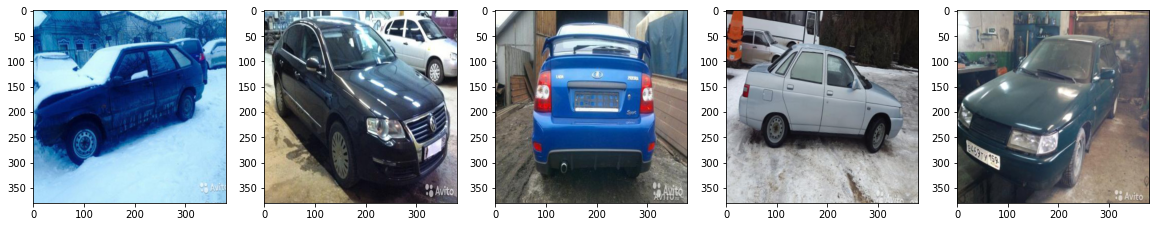

In [28]:
'''
TTA_sub_datagen = ImageDataGenerator( preprocessing_function = albument)

TTA_sub_generator = TTA_sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=test_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=32,
    shuffle=False
)

show_first_images(TTA_sub_generator, labels=False)
# TTA_sub_generator.reset()
# show_first_images(TTA_sub_generator, labels=False)
'''

In [29]:
'''
multi_predictions = []
for _ in range(5):
  # sub_generator.reset()
  multi_predictions.append(model.predict(TTA_sub_generator, verbose=1))
multi_predictions = np.array(multi_predictions)
print(multi_predictions.shape)
final_predictions = multi_predictions.mean(axis=0).argmax(axis=-1)
print(final_predictions)


TTA_submission = pd.DataFrame({ 'Id': sub_generator.filenames, 'Category': final_predictions}, columns=['Id', 'Category'])
TTA_submission.to_csv(subm_path+'220211_B0_TTA_01.csv', index=False)
'''

209/209 [==============================] - 43s 207ms/step
(5, 6675, 10)
[7 6 4 ... 1 3 4]


In [26]:
# Другой хвостик
# model3 = Sequential([
#  EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False), #предобученная нейросеть из модуля keras.applications
#  GlobalAveragePooling2D(),
#  Dense(256,activation='relu', bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)),
#  BatchNormalization(),
#  Dropout(0.25),
#  Dense(10)
#])
#
#model3.compile( loss=CategoricalCrossentropy(from_logits=True), optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)), metrics='accuracy'
#)